# Periodicity detector class tutorial
-----------------------------------

### 1 Using the PeriodicityDetector class to run PDC on simulated velocity times series

`Observations` class enables one to load observation data from a given folder 
and place it into a TimeSeries object, or to load an existing time series. 
In this case we will choose the latter. 

In [1]:
import sys, numpy as np

In [2]:
# A time series object is the place holder for the set
# of spectra an\or velocities we wish to analyze. 
from sparta.Auxil.TimeSeries import TimeSeries

# Observations class recieves a TimeSeries object and
# manages the relevant routines.
from sparta import Observations

# Is we wish ot directly hangle datasets of spectra, 
# this is done using the Spectrum class.
from sparta.UNICOR.Spectrum import Spectrum

# The Template class is a wrapper foor the spectrum class,
# that enables retrieval of spectra from online PHOENIX 
# repositories, and some additional features.
from sparta.UNICOR.Template import Template

In the example below we simulate a sinewave of scalars. We can think of it as the radial velocity of a star. 

In [3]:
# Generate timeseries as a sinewave with some noise...
period = 5
size   = 25
times  = [(np.random.rand() * 100) for _ in range(size)]
vals   = [np.sin(t * 2 * np.pi / period) + 0.3*np.random.randn() for t in times]

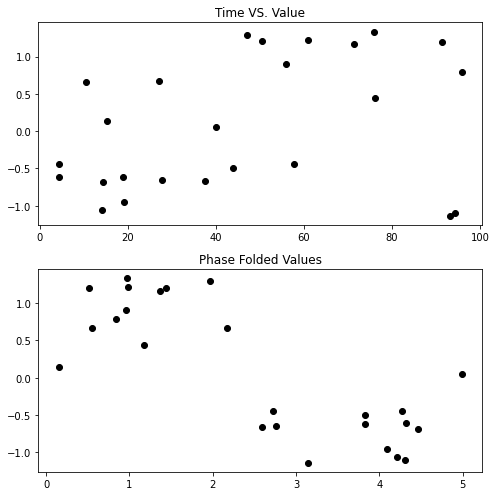

In [4]:
# Read the data into the time series
time_series = TimeSeries(size=size, times=times, vals=vals, fold_period=period)

# You can plot it if you want
time_series.plot_velocities()


#### The Observations class recieves the TimeSeries object, and initialized


In [5]:
# If we wish the Observations object to read a set of spectra
# we can initialize it with some requirements, such as the wavelength range 
# that we wish to use of the SNR limits. The simplest thing to do, though, 
# is probably feeding it with a timeseries object directly.

obs = Observations(time_series=time_series)

In [6]:
# Another initizalization that is required, is the initialization of the frequency
# grid. This is slightly weird, but we have several different periodograms
# and dound it useful that they use the same rage by default. 
# This row essentially initializes a PeriodicityDetector object and puts it in
# observations, where the data are stored.

obs.initialize_periodicity_detector(periodogram_grid_resolution=1000, freq_range=(0.01, 1))

<br />
Now using the PeriodicityDetector to detect periodicity in the data using the GLS and PDC method is posible:
<br />

In [7]:
_ = obs.periodicity_detector.calc_PDC(fast=False)
_ = obs.periodicity_detector.calc_GLS()

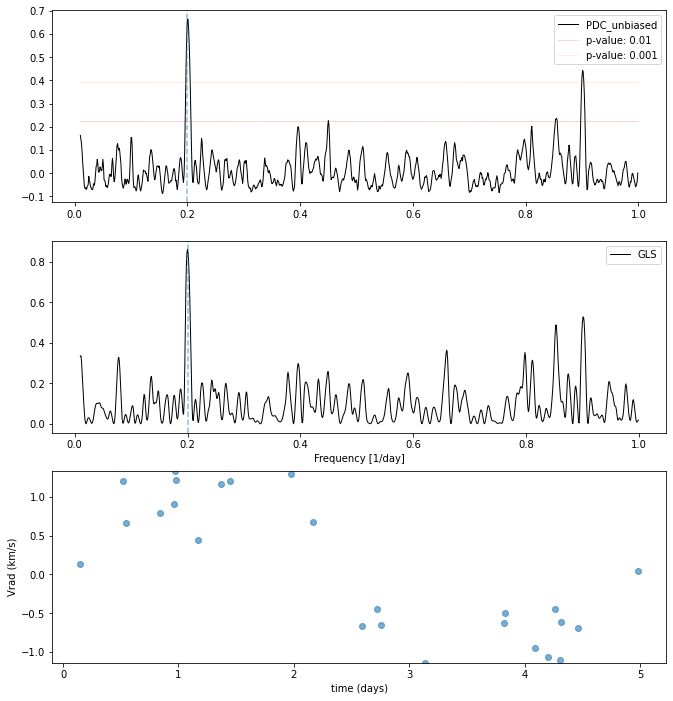

In [8]:
# If we have a suspected period, we can provide it so that it is 
# plotted as a vertical line inf the periodogram
obs.periodicity_detector.period_truth = [5]
obs.periodicity_detector.plot_periodograms(annotate_pval=[1e-2,1e-3], plot_vals=True)


### 2. Using the PeriodicityDetector class to run USuRPer on simulated spectra

In the following code segment we simulate a single-line stereoscopic binary system (SB1) and using sparta classes to detect 
periodicity in the data using USuRPer.

First we initiate a Template object containing Phoenix library synthetic spectra.

In [9]:
# Assigning sun-like stellar parameters to the simulated spectra
temp = 4900
log_g = 4.5
metal = 0
alpha = 0

# Choosing wavelength range (Angstrom units)
min_val = 4900
max_val = 5100

# Loading a Phoenix synthetic spectrum
template = Template(temp=temp, log_g=log_g, metal=metal, 
                    alpha=alpha, min_val=min_val, max_val=max_val)

At this point, we use the template to simulate a single-line stereoscopic binary system (SB1) by generating 50 visits over 100 days,
and shifting them in sinusoidal wave velocities.
We represent the series in a TimeSeries object, then assigning it to an Observations object.

In [10]:
p        = 5 # Assigning a five-day long period to the system.
semi_amp = 100 # Assigning a 100 km/s amplitude to the velocity semi amplitude
N        = 50 # Setting the number of observations to be 50

times = [(np.random.rand() * 100) for _ in range(N)]
vals  = [semi_amp * np.sin(2 * t * np.pi / p) for t in times]
visit_spec_list = []

for i, v in enumerate(vals):
    new_wl = template.doppler(v)

    new_temp = Spectrum(wv=new_wl, sp=template.add_noise(-1)).SpecPreProccess()
    visit_spec_list.append(new_temp)

ts  = TimeSeries(size=N, times=times, vals=visit_spec_list,
                       calculated_vrad_list=[])
obs = Observations(time_series=ts)

Now we can run USURPER to detect periodicity in the observations, and print out the resulted periodogram.

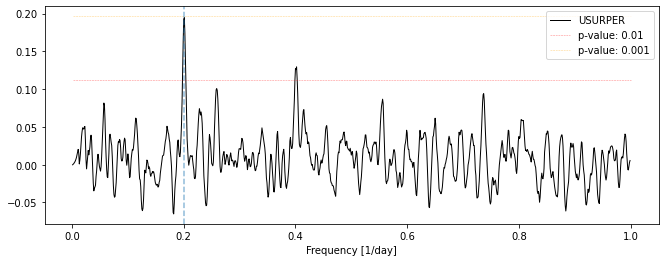

In [11]:
obs.initialize_periodicity_detector(freq_range=(1/1000, 1), periodogram_grid_resolution=1000)
obs.periodicity_detector.calc_USURPER(fast=False)
obs.periodicity_detector.period_truth = [5]
obs.periodicity_detector.plot_periodograms(annotate_pval=[1e-2,1e-3])